# 50 epochs

In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import DatasetIN12, IN12_MEAN, IN12_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [ ]:
learning_rate = 0.001
epochs = 50
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/IN12_clear_alexnet"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/IN12_blur_alexnet"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [ ]:
prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=IN12_MEAN, std=IN12_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=IN12_MEAN, std=IN12_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load IN-12 dataset

In [ ]:
train_dataset = DatasetIN12(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = DatasetIN12(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = DatasetIN12(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 18000
Val set size: 1200
Test set size: 1200


### Create AlexNet model

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=12).to(device)
blur_model = AlexNetSup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, weight_decay=1e-5)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/50, Clear train acc: 8.1975%, Clear train loss: 2.4910, Clear val acc: 0.00%, Clear val loss: 2.5359
Epoch 0/50, Blur train acc: 8.5714%, Blur train loss: 2.4915, Blur val acc: 10.84%, Blur val loss: 2.4821


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 10:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 30:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 10:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 30:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,  # Optionally log training loss from the training loop
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/50, Clear train acc: 26.1663%, Clear train loss: 2.1157, Clear val acc: 29.30%, Clear val loss: 2.0595
Epoch 1/50, Blur train acc: 23.6607%, Blur train loss: 2.1956, Blur val acc: 26.56%, Blur val loss: 2.1028
Epoch 2/50, Clear train acc: 32.6228%, Clear train loss: 1.9611, Clear val acc: 35.16%, Clear val loss: 1.9427
Epoch 2/50, Blur train acc: 26.4062%, Blur train loss: 2.1295, Blur val acc: 27.54%, Blur val loss: 2.1107
Epoch 3/50, Clear train acc: 39.4029%, Clear train loss: 1.8060, Clear val acc: 43.36%, Clear val loss: 1.7185
Epoch 3/50, Blur train acc: 31.4621%, Blur train loss: 2.0025, Blur val acc: 33.98%, Blur val loss: 1.9389
Epoch 4/50, Clear train acc: 43.7444%, Clear train loss: 1.6499, Clear val acc: 46.19%, Clear val loss: 1.5741
Epoch 4/50, Blur train acc: 33.8951%, Blur train loss: 1.9201, Blur val acc: 38.48%, Blur val loss: 1.9903
Epoch 5/50, Clear train acc: 48.7388%, Clear train loss: 1.5157, Clear val acc: 55.86%, Clear val loss: 1.3626
Epoch 5/50, Blur 

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

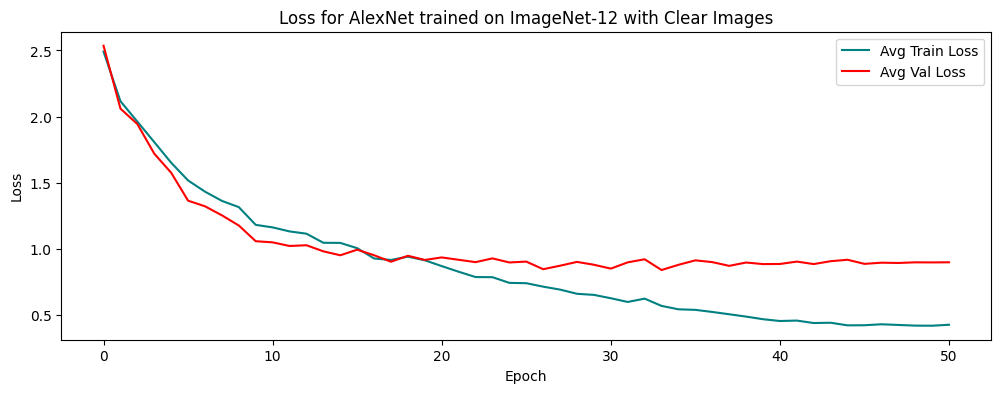

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-12 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

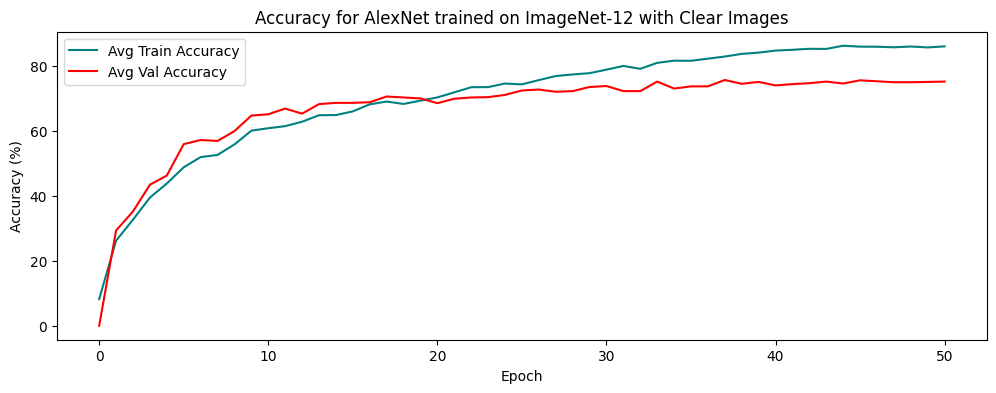

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-12 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

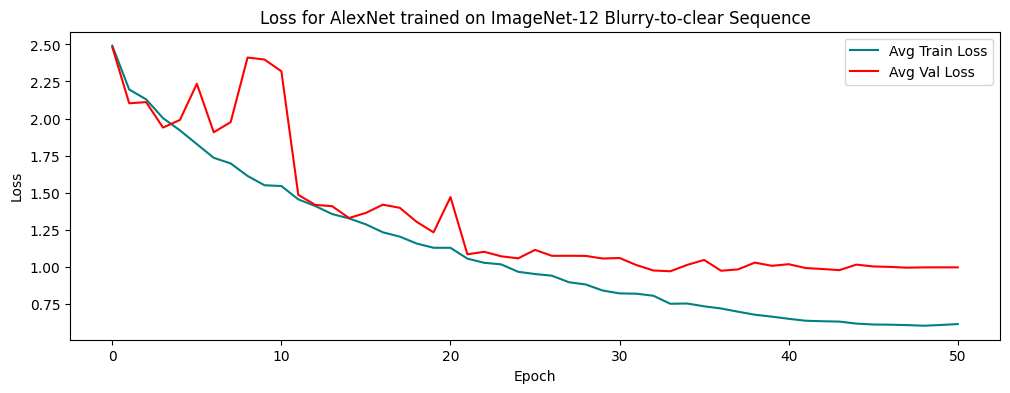

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-12 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

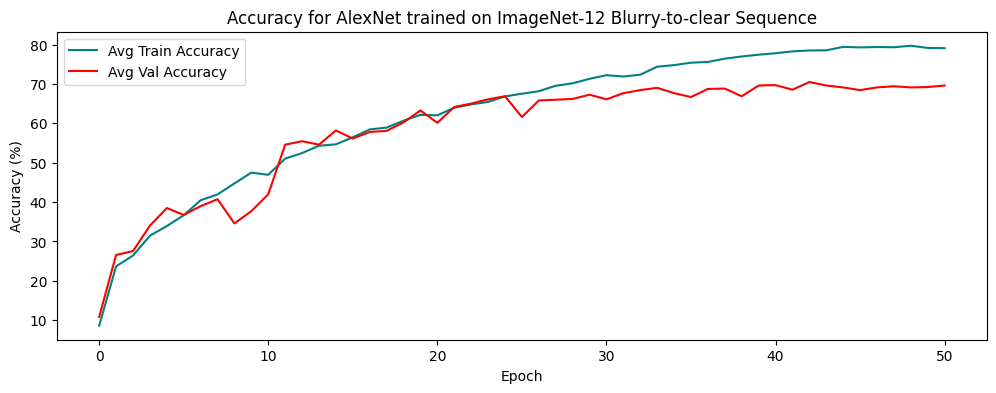

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-12 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# 100 epochs

In [ ]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blurred_images = blurred_images.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(blurred_images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/100, Clear train acc: 8.5435%, Clear train loss: 2.4950, Clear val acc: 11.13%, Clear val loss: 2.4967
Epoch 0/100, Blur train acc: 8.3426%, Blur train loss: 2.4863, Blur val acc: 9.57%, Blur val loss: 2.4876


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 60:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 60:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Clear train acc: 26.4565%, Clear train loss: 2.1317, Clear val acc: 26.17%, Clear val loss: 2.0933
Epoch 1/100, Blur train acc: 22.6228%, Blur train loss: 2.2266, Blur val acc: 18.95%, Blur val loss: 2.2159
Epoch 2/100, Clear train acc: 32.2879%, Clear train loss: 2.0570, Clear val acc: 39.16%, Clear val loss: 1.9850
Epoch 2/100, Blur train acc: 26.6797%, Blur train loss: 2.1599, Blur val acc: 30.57%, Blur val loss: 2.0318
Epoch 3/100, Clear train acc: 36.1942%, Clear train loss: 1.8635, Clear val acc: 41.21%, Clear val loss: 1.7394
Epoch 3/100, Blur train acc: 31.4118%, Blur train loss: 1.9921, Blur val acc: 33.30%, Blur val loss: 1.8936
Epoch 4/100, Clear train acc: 41.3951%, Clear train loss: 1.7130, Clear val acc: 45.80%, Clear val loss: 1.5851
Epoch 4/100, Blur train acc: 33.8560%, Blur train loss: 1.9213, Blur val acc: 38.57%, Blur val loss: 1.9037
Epoch 5/100, Clear train acc: 48.9174%, Clear train loss: 1.5283, Clear val acc: 49.80%, Clear val loss: 1.4510
Epoch 5/

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

In [19]:
import pickle

output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"

with open(f"{output_dir_clear}/metrics.pkl", "rb") as metrics_file:
    clear_metrics = pickle.load(metrics_file)

clear_train_correct = clear_metrics['clear_train_correct']
clear_val_correct = clear_metrics['clear_val_correct']
clear_train_loss_list = clear_metrics['clear_train_loss_list']
clear_val_loss_list = clear_metrics['clear_val_loss_list']

with open(f"{output_dir_blur}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

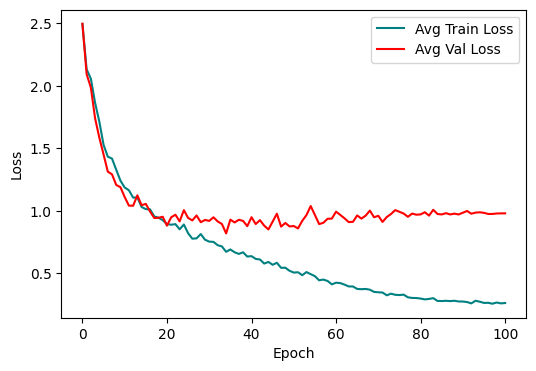

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on ImageNet-12 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

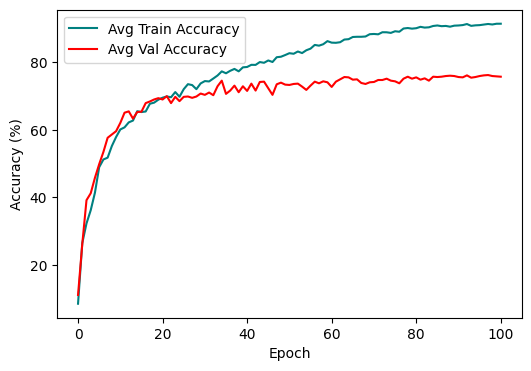

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on ImageNet-12 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

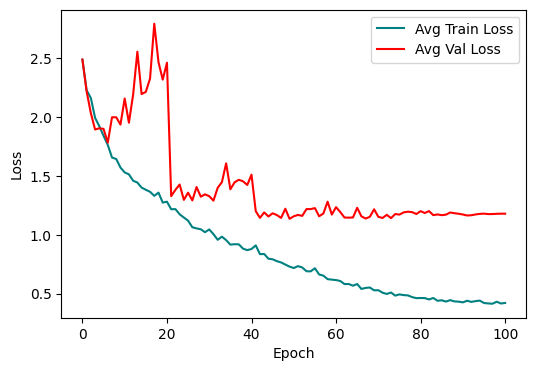

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on ImageNet-12 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

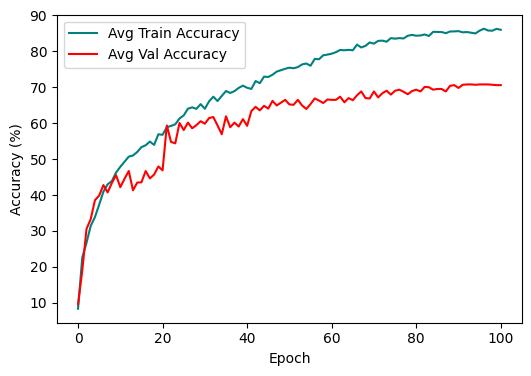

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on ImageNet-12 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# IN12 full blur training

In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import DatasetIN12, IN12_MEAN, IN12_STD
from torch.utils.data import DataLoader

epochs = 100
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN12_full_blur_2"

os.makedirs(output_dir, exist_ok=True)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=IN12_MEAN, std=IN12_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=IN12_MEAN, std=IN12_STD)
])

train_dataset = DatasetIN12(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = DatasetIN12(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = DatasetIN12(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 18000
Val set size: 1200
Test set size: 1200


In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
blur_train_correct, blur_val_correct = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs = []

blur_model.eval()

# Training metrics initialization
blur_train_corr, total_train = 0, 0
blur_train_loss = 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        blur_y_pred = blur_model(images)

        # Calculate loss values
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
blur_train_accuracy = (blur_train_corr / total_train) * 100
blur_train_loss /= total_train

# Validation metrics initialization
blur_val_corr, total_val = 0, 0
blur_val_loss = 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
blur_val_accuracy = (blur_val_corr / total_val) * 100
blur_val_loss /= total_val

# Save results for plotting
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
blur_train_loss_list.append(blur_train_loss)
blur_val_loss_list.append(blur_val_loss)

blur_log_entry = (f"Epoch 0/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs.append(blur_log_entry)

Epoch 0/100, Train acc: 8.3315%, Train loss: 2.4836, Val acc: 9.77%, Val loss: 2.4838


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'scheduler_state_dict': blur_combined_scheduler.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Train acc: 25.2790%, Train loss: 2.1734, Val acc: 29.20%, Val loss: 2.0696
Epoch 2/100, Train acc: 27.3103%, Train loss: 2.1075, Val acc: 30.37%, Val loss: 2.0344
Epoch 3/100, Train acc: 32.5949%, Train loss: 1.9599, Val acc: 37.99%, Val loss: 1.7978
Epoch 4/100, Train acc: 34.4196%, Train loss: 1.9074, Val acc: 41.02%, Val loss: 1.7868
Epoch 5/100, Train acc: 37.0647%, Train loss: 1.8568, Val acc: 43.75%, Val loss: 1.7533
Epoch 6/100, Train acc: 41.2500%, Train loss: 1.7251, Val acc: 44.04%, Val loss: 1.6474
Epoch 7/100, Train acc: 43.0246%, Train loss: 1.6750, Val acc: 46.97%, Val loss: 1.5949
Epoch 8/100, Train acc: 45.5190%, Train loss: 1.6024, Val acc: 48.54%, Val loss: 1.5227
Epoch 9/100, Train acc: 44.8326%, Train loss: 1.6064, Val acc: 45.02%, Val loss: 1.5673
Epoch 10/100, Train acc: 48.3873%, Train loss: 1.5259, Val acc: 49.61%, Val loss: 1.4675
Epoch 11/100, Train acc: 49.0848%, Train loss: 1.4905, Val acc: 52.93%, Val loss: 1.4213
Epoch 12/100, Train acc: 49.44

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

### Plot loss and accuracy

In [4]:
import pickle

output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN12_full_blur_2"

with open(f"{output_dir}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


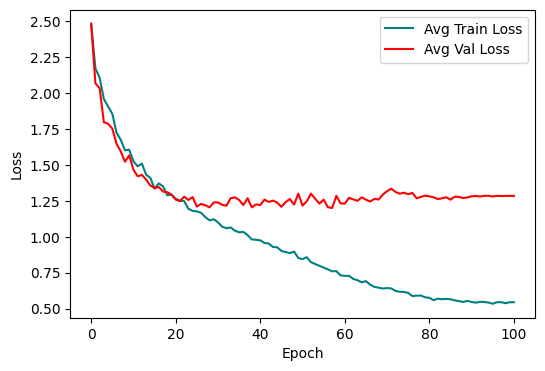

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on ImageNet-12 with Blurred Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

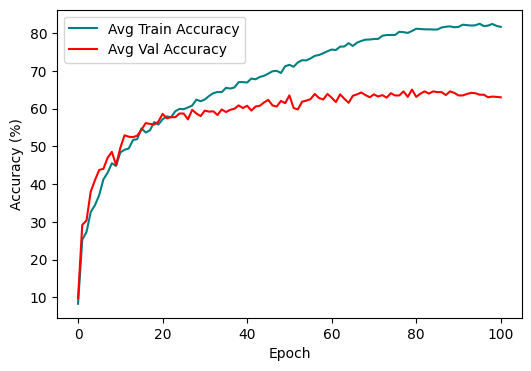

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on ImageNet-12 with Blurred Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Continue training blur to 100 epochs

In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import DatasetIN12, IN12_MEAN, IN12_STD
from torch.utils.data import DataLoader

epochs = 100
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN12_full_blur"

os.makedirs(output_dir, exist_ok=True)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=IN12_MEAN, std=IN12_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=IN12_MEAN, std=IN12_STD)
])

train_dataset = DatasetIN12(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = DatasetIN12(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = DatasetIN12(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

import re
import os
import torch
from utils import add_blur_with

text = """
Epoch 0/50, Train acc: 8.7500%, Train loss: 2.4850, Val acc: 10.45%, Val loss: 2.4829
Epoch 1/50, Train acc: 25.8315%, Train loss: 2.1455, Val acc: 30.66%, Val loss: 2.0465
Epoch 2/50, Train acc: 24.3750%, Train loss: 2.1967, Val acc: 26.46%, Val loss: 2.1032
Epoch 3/50, Train acc: 31.5513%, Train loss: 1.9923, Val acc: 35.84%, Val loss: 1.8780
Epoch 4/50, Train acc: 34.2299%, Train loss: 1.9167, Val acc: 40.53%, Val loss: 1.7584
Epoch 5/50, Train acc: 36.1663%, Train loss: 1.8569, Val acc: 39.16%, Val loss: 1.7486
Epoch 6/50, Train acc: 38.9955%, Train loss: 1.7905, Val acc: 42.38%, Val loss: 1.6915
Epoch 7/50, Train acc: 42.9241%, Train loss: 1.6654, Val acc: 49.22%, Val loss: 1.5399
Epoch 8/50, Train acc: 45.7031%, Train loss: 1.6007, Val acc: 50.39%, Val loss: 1.4994
Epoch 9/50, Train acc: 47.1150%, Train loss: 1.5754, Val acc: 51.66%, Val loss: 1.4990
Epoch 10/50, Train acc: 46.9029%, Train loss: 1.5667, Val acc: 50.20%, Val loss: 1.4893
Epoch 11/50, Train acc: 49.7266%, Train loss: 1.4912, Val acc: 54.88%, Val loss: 1.3776
Epoch 12/50, Train acc: 48.4487%, Train loss: 1.4946, Val acc: 51.66%, Val loss: 1.4480
Epoch 13/50, Train acc: 51.2277%, Train loss: 1.4233, Val acc: 52.54%, Val loss: 1.4003
Epoch 14/50, Train acc: 52.6842%, Train loss: 1.3802, Val acc: 54.59%, Val loss: 1.3307
Epoch 15/50, Train acc: 54.1797%, Train loss: 1.3591, Val acc: 54.20%, Val loss: 1.3480
Epoch 16/50, Train acc: 55.0000%, Train loss: 1.3194, Val acc: 56.15%, Val loss: 1.2981
Epoch 17/50, Train acc: 55.7813%, Train loss: 1.3040, Val acc: 56.74%, Val loss: 1.3156
Epoch 18/50, Train acc: 57.0647%, Train loss: 1.2757, Val acc: 59.18%, Val loss: 1.2675
Epoch 19/50, Train acc: 56.8862%, Train loss: 1.2612, Val acc: 58.40%, Val loss: 1.2838
Epoch 20/50, Train acc: 58.8895%, Train loss: 1.2152, Val acc: 57.03%, Val loss: 1.2759
Epoch 21/50, Train acc: 59.0290%, Train loss: 1.2185, Val acc: 57.62%, Val loss: 1.2291
Epoch 22/50, Train acc: 60.9152%, Train loss: 1.1609, Val acc: 58.59%, Val loss: 1.2385
Epoch 23/50, Train acc: 60.7868%, Train loss: 1.1592, Val acc: 58.79%, Val loss: 1.2528
Epoch 24/50, Train acc: 60.9821%, Train loss: 1.1355, Val acc: 58.40%, Val loss: 1.2417
Epoch 25/50, Train acc: 63.2422%, Train loss: 1.0814, Val acc: 59.57%, Val loss: 1.2096
Epoch 26/50, Train acc: 63.8058%, Train loss: 1.0680, Val acc: 62.01%, Val loss: 1.1964
Epoch 27/50, Train acc: 64.8661%, Train loss: 1.0399, Val acc: 61.13%, Val loss: 1.2113
Epoch 28/50, Train acc: 64.2522%, Train loss: 1.0599, Val acc: 59.57%, Val loss: 1.2634
Epoch 29/50, Train acc: 65.7757%, Train loss: 1.0094, Val acc: 60.64%, Val loss: 1.1986
Epoch 30/50, Train acc: 67.2879%, Train loss: 0.9750, Val acc: 60.35%, Val loss: 1.2058
Epoch 31/50, Train acc: 67.0480%, Train loss: 0.9705, Val acc: 59.47%, Val loss: 1.2146
Epoch 32/50, Train acc: 68.3426%, Train loss: 0.9464, Val acc: 61.43%, Val loss: 1.1944
Epoch 33/50, Train acc: 68.8783%, Train loss: 0.9241, Val acc: 61.82%, Val loss: 1.2135
Epoch 34/50, Train acc: 69.3638%, Train loss: 0.9148, Val acc: 60.55%, Val loss: 1.2492
Epoch 35/50, Train acc: 70.2567%, Train loss: 0.8763, Val acc: 62.01%, Val loss: 1.2046
Epoch 36/50, Train acc: 70.1116%, Train loss: 0.8852, Val acc: 61.43%, Val loss: 1.2255
Epoch 37/50, Train acc: 70.9040%, Train loss: 0.8597, Val acc: 62.11%, Val loss: 1.2065
Epoch 38/50, Train acc: 72.1150%, Train loss: 0.8254, Val acc: 61.72%, Val loss: 1.2044
Epoch 39/50, Train acc: 71.9699%, Train loss: 0.8252, Val acc: 61.91%, Val loss: 1.2368
Epoch 40/50, Train acc: 72.4107%, Train loss: 0.8204, Val acc: 61.91%, Val loss: 1.2040
Epoch 41/50, Train acc: 72.9520%, Train loss: 0.7967, Val acc: 63.28%, Val loss: 1.2083
Epoch 42/50, Train acc: 72.7344%, Train loss: 0.8033, Val acc: 62.30%, Val loss: 1.2263
Epoch 43/50, Train acc: 73.1641%, Train loss: 0.7857, Val acc: 62.70%, Val loss: 1.2076
Epoch 44/50, Train acc: 73.5603%, Train loss: 0.7867, Val acc: 63.18%, Val loss: 1.2059
Epoch 45/50, Train acc: 73.5993%, Train loss: 0.7771, Val acc: 62.70%, Val loss: 1.2194
Epoch 46/50, Train acc: 73.6217%, Train loss: 0.7794, Val acc: 62.70%, Val loss: 1.2005
Epoch 47/50, Train acc: 74.2411%, Train loss: 0.7676, Val acc: 62.70%, Val loss: 1.2091
Epoch 48/50, Train acc: 74.2467%, Train loss: 0.7643, Val acc: 62.89%, Val loss: 1.2079
Epoch 49/50, Train acc: 74.5703%, Train loss: 0.7690, Val acc: 62.99%, Val loss: 1.2089
Epoch 50/50, Train acc: 73.8616%, Train loss: 0.7732, Val acc: 62.99%, Val loss: 1.2081
"""

pattern_blur = r"Train acc: ([\d.]+)%, Train loss: ([\d.]+), Val acc: ([\d.]+)%, Val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
logs = text.strip().split("\n")

resume_epoch = 50
blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{resume_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {resume_epoch}...")
    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    # Load model and optimizer states
    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])
    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Update starting epoch from the checkpoint
    start_epoch = blur_checkpoint.get('epoch', resume_epoch)
    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode to verify weights are loaded correctly
blur_model.eval()

# Run a quick validation check
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)
        blur_predicted = torch.max(blur_pred, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100
print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dev set size: 18000
Val set size: 1200
Test set size: 1200
Loading checkpoint from epoch 50...
Successfully resumed training from epoch 50.
Validation Accuracy after checkpoint load - Blur Model: 62.99%


In [ ]:
for epoch in range(start_epoch, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 51/100, Train acc: 74.4810%, Train loss: 0.7643, Val acc: 62.99%, Val loss: 1.2081
Epoch 52/100, Train acc: 74.1685%, Train loss: 0.7737, Val acc: 62.99%, Val loss: 1.2081
Epoch 53/100, Train acc: 64.4643%, Train loss: 1.0487, Val acc: 58.69%, Val loss: 1.2887
Epoch 54/100, Train acc: 64.4475%, Train loss: 1.0514, Val acc: 58.30%, Val loss: 1.2978
Epoch 55/100, Train acc: 62.6228%, Train loss: 1.1013, Val acc: 56.25%, Val loss: 1.2981
Epoch 56/100, Train acc: 64.9777%, Train loss: 1.0358, Val acc: 59.47%, Val loss: 1.2619
Epoch 57/100, Train acc: 64.3638%, Train loss: 1.0507, Val acc: 58.01%, Val loss: 1.2851
Epoch 58/100, Train acc: 64.7154%, Train loss: 1.0364, Val acc: 58.11%, Val loss: 1.2674
Epoch 59/100, Train acc: 63.4542%, Train loss: 1.0734, Val acc: 57.23%, Val loss: 1.3027
Epoch 60/100, Train acc: 65.1339%, Train loss: 1.0192, Val acc: 61.72%, Val loss: 1.2049
Epoch 61/100, Train acc: 64.6150%, Train loss: 1.0375, Val acc: 59.96%, Val loss: 1.2579
Epoch 62/100, Train a

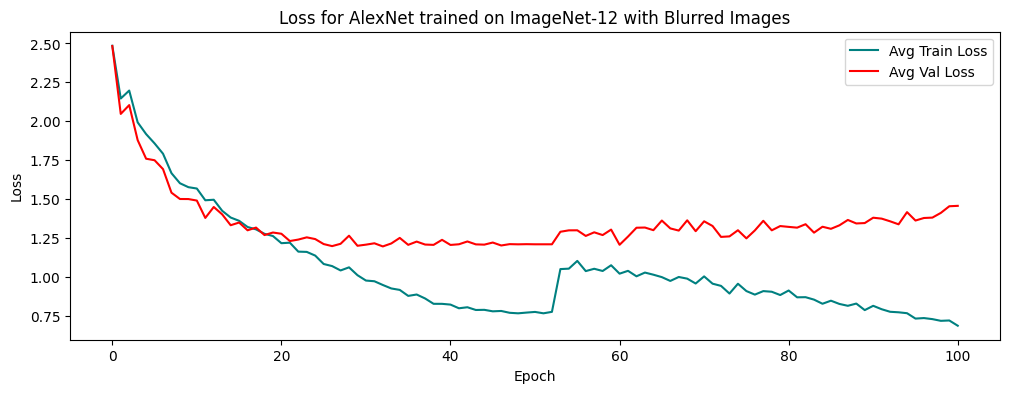

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-12 with Blurred Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

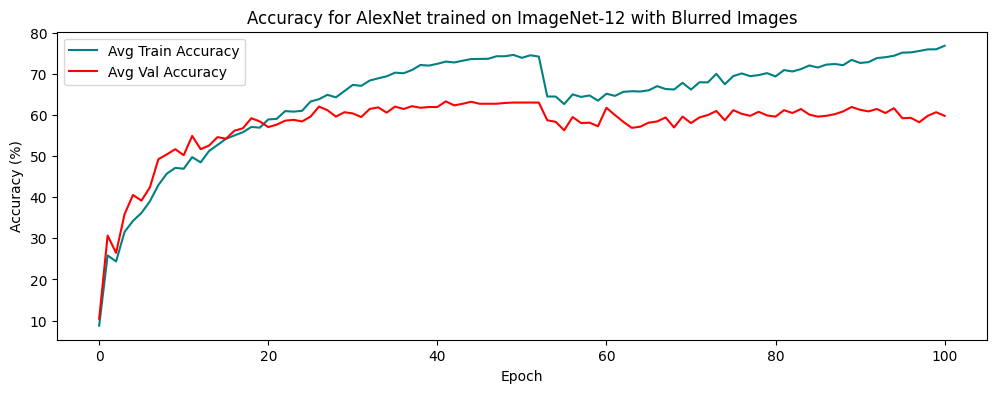

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-12 with Blurred Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()